<h1>Preprocessing Site Names<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li>
        <span><a href="#Packages-and-functions" data-toc-modified-id="Packages-and-functions-1">
        <span class="toc-item-num">1&nbsp;&nbsp;</span>Packages and functions</a></span>
        </li>
        <li>
            <span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2">
            <span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span>
            <ul class="toc-item">
                <li>
                <span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span>
                <ul class="toc-item">
                <li>
                <span><a href="#Match-orgunitlevel4-to-Geob-Adm-3" data-toc-modified-id="Match-orgunitlevel4-to-Geob-Adm-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel4 to Geob Adm 3</a></span>
                </li>
                <li>
                <span><a href="#Match-orgunitlevel3-to-Geob-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-Geob-Adm-2-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel3 to Geob Adm 2</a></span>
                </li>
                <li>
                <span><a href="#Match-orgunitlevel2-to-Geob-Adm-1" data-toc-modified-id="Match-orgunitlevel2-to-Geob-Adm-1-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Match orgunitlevel2 to Geob Adm 1</a></span>
                </li>
                </ul>
            </li>
        </ul>
    </li>
</div>

Version: April 11, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources of geo-located health facilities, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 4)
- FEWS Admin-2 boundaries (updated post 2017)

# Packages and functions

In [1]:
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

# local imports
import preprocessing_utils as ppu
import search_utils as ssu

In [2]:
from ctypes.util import find_library
find_library('c')

'/usr/lib/libc.dylib'

# Prepare and match admin boundary data

In [3]:
iso3 = "ETH"
country = "Ethiopia"
input_dir = "/Users/dianaholcomb/Documents/GWU/6501_Capstone/workspace/data"
input_filename = f"hierarchy/{country}_health_facilities.csv"
output_dir = join(input_dir, "output", iso3)
num_admin_levels = 3
num_org_levels = 4
COLS_TO_DROP = []
CHECK_DUPLICATE_COLS = ['orgunitlevel2', 'orgunitlevel3', 'orgunitlevel4', 'orgunitlevel5', 'orgunitlevel6']
geoboundary_words_to_remove = [" City Council", " District Council", " Municipal Council", " District"]
org_level_words_to_remove = [
    # 5+ words
    " Gynie And Internal Medicine Speciality Clinic", " Internal Medicine And Obstetric And Gayni Speciality Clinic",
    " Maternal And Child Health Specialty Center Speciality Clinic", " Obstatric And Gyencology Speciality Clinic",
    " Obstetric And Gynacology Speciality Clinic", " Obstetrics And Gynecology Specialty Clinic",
    " Specailty Surgucal Center Speciality Center",
    " Specialized Internal Medicine And Surgical Center", " Surgical And Medical Speciality Center",
    # 4 words
    " Gyne And Obste Clinic", " Gyn Obs Spe Clinic", " Interanal Medicine Specialty Clinic",
    " Internal Medicine Medical Center", " Internal Medicine Specialty Clinic", " Internal Medicine  Specialty Clinic",
    " Maternal And Child Health Clinic",
    " Mothers A And Childrens", " Obstetrics And  Gynecology Clinic", " Ped Atric Specalty Clinic",
    " Police Commission Primary Clinic", " Surgical Special Higher Clinic",
    # 3 words
    " Al Health Bureau", " Dental Speciality Clinic", " Dental Specialty Clinic", " Dental Specility Clinic",
    " Dermatology Speciality Clinic",
    " Eye Speciality Clinic",
    " Eye Specialty Clinic",
    " Gyne And Obste", " Interanal Medicinespecialty Clinic", " Internal Medicine Center",
    " Internal Specality Clinic", " Maternal And Child", " Mch Specality Center", " Mch Specialist Clinic",
    " Mch Speciality Centre",
    " Medium Dental Clinic", " Medium Primary Clinic", " Memoreal General Hospital", " Memorial Referral Hospital",
    " Mothers And Pdiatrics Center", " Obstetrics  And Gynecology", " Od And Imsc", " Pediatric Specialty Clinic",
    " Pediatrics Speciality Clinic", " Regional Health Bureau", " Special Dental Clinic", " Special  Eye Clinic",
    " Speciality Dental Clinic", " Specialized Eye Clinic",
    " Specialized Referral Hospital", " Surgery Specialty Clinic", " Surgical Specialty Clinic",
    # 2 words
    " Administration Ho", " Bygyn Sp.Clinic", " City Admin", " Comprehensive And", " Dental Clinic", " Dental Small",
    " General Hospital", "health Center", # no space intentional here
    " Health Center", " Helth Center", " Health Clinic", " Health Office", " Health Post", " Healthcare Foundation",
    " Higher Obsgyn", "  Higher Pediatric", " Internalanddermatology Sp.Clinic", " Internal Medicine",
    " Internalspecality Clinic", " Lower Clinic", " Maternity Hospital", " Mch Center", " Mch Hospital",
    " Medical Center", " Medicinespecialty Clinic", " Mediu Clinic", " Mediu, Cli", " Medium Cilinic",
    " Medium Clinc", " Medium Clinic", " Medium Clininc", " Midium Clinic", " Middium Clinic", " Obygyn Sp.Clinic",
    " Optamology,Dermatology Andinternal", " Pediatric Clinic", " Pediatric Sp.Clinic",
    " Penediatric,Obey-Gayneand Internal", " Primary Clinic",  " Primary Hospital", " Primary Hosp",
    " Referal Hospital", " Referral Hospital", " Specality Clinic", " Specalty Clinic", " Speciaility  Clinic",
    " Special Clinic", " Speciality Center", " Specialty Clinic", " Speciality Clinic",
    " Specialized Hospital", " Sub City",
    # 1 word
    " Administration", " Adminstration", " Center", " Centre", " Clinic", " Clinin", " Comprehensive", " Dent", " Dental",
    " Dental", " Dermatology", " District", " Dm", " Genaral", " General", " Gynecology", " Hc", " Higher", " Hospital",
    " Interanal",
    " International", " Mclinic", " Medium", " Memorial", " Midium", " Opclinic", " Operational", " Pediatrics",
    " Pediatric", " Phcu", " PHCU",  " Primary", " Primiry", " Rural", " Sp.Clinic", " Specialized", " Subcity",
    " Surgery", " Surgical",
    " Town", " Worho", " WorHO", " Zhd", " ZHD"
]

In [4]:
geob_arr = ppu.get_geoboundaries(num_admin_levels, iso3)

In [5]:
master_table = ppu.process_masterDF(input_dir, input_filename, num_org_levels, check_dupe_cols=CHECK_DUPLICATE_COLS,
                                    cols_to_drop=COLS_TO_DROP)

Len of original data: 27910
Len of clean data: 27908

Unique Level 2: 15
Unique Level 3: 218
Unique Level 4: 2572


In [6]:
geobList_arr = []
for idx, geob in enumerate(geob_arr):
    admIdx = idx+1
    print(f"Unique Geoboundaries Adm {admIdx}: {len(geob)}")
    geob_list = list(geob.shapeName)
    geob_list.sort()
    geobList_arr.append(geob_list)

Unique Geoboundaries Adm 1: 11
Unique Geoboundaries Adm 2: 74
Unique Geoboundaries Adm 3: 690


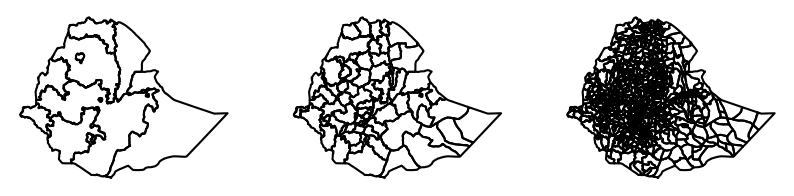

In [7]:
fig, ax = plt.subplots(1, num_admin_levels, figsize=(10,10))
for idx, geob in enumerate(geob_arr):
    geob.boundary.plot(ax=ax[idx], color='black').set_axis_off()

## Match health list admin names to shapefile admin names
### Match highest Geob Adm to orgunitlevel
Try using fuzzy matching  

In [8]:
if num_admin_levels == 2:
    org_unit_level = 3
elif  num_admin_levels > 2:
    org_unit_level = 4
else:
    org_unit_level = 1

print(f"Org Unit Level: {org_unit_level}")

Org Unit Level: 4


# Do Matching

In [9]:
curr_geob_lvl = num_admin_levels
curr_org_lvl = org_unit_level
master_table_copy = master_table.copy()

for geobIdx in range(num_admin_levels-1, -1, -1): # reverse loop
    print(f"-----Master list level: {curr_org_lvl}, Geoboundaries level: {curr_geob_lvl}-----")

    master_table_copy.loc[:, f"orgunitlevel{curr_org_lvl}_edit"] = master_table_copy[f"orgunitlevel{curr_org_lvl}"]

    geob_list = ppu.remove_words(geob_arr[geobIdx], "shapeName", geoboundary_words_to_remove)

    org_lvl_list = ppu.remove_words(master_table_copy, f"orgunitlevel{curr_org_lvl}_edit", org_level_words_to_remove)

    # Print names to inspect
    print(org_lvl_list)
    ppu.inspect_level_names(curr_org_lvl, org_lvl_list, curr_geob_lvl, geobList_arr[geobIdx])

    table_adm_matches = ssu.find_matches(org_lvl_list.tolist(), geob_list.tolist(), 30, curr_org_lvl, curr_geob_lvl)
    matches_pct = (len(table_adm_matches) / len(org_lvl_list))
    print('Matches for Org level {}, Geob level {}: {:.2f}%'.format(curr_org_lvl, curr_geob_lvl, matches_pct*100))

    # Loop through each row in master table, and add new attribute names (adm3 and adm2), if the names produced
    # matches in the lookup tables
    for idx, row in master_table_copy.iterrows():
        if row[f"orgunitlevel{curr_org_lvl}_edit"] in list(table_adm_matches[f"name_geob{curr_org_lvl}"]):
            match = table_adm_matches.loc[table_adm_matches[f"name_geob{curr_org_lvl}"] == row[f"orgunitlevel{curr_org_lvl}_edit"], f"name_geob{curr_geob_lvl}"].iloc[0]
            master_table_copy.loc[idx, f'adm{curr_geob_lvl}'] = match

    if f"adm{curr_geob_lvl}" in master_table_copy.columns:
        notFound = master_table_copy[f"adm{curr_geob_lvl}"].isna().sum()
        print(f"Num not found: {notFound}")
    else:
        print("Num not found: 0")

    print("Matches 80% or less:")
    print(table_adm_matches.loc[table_adm_matches.score<=80])

    # iterate down
    curr_geob_lvl -= 1
    curr_org_lvl -= 1
    print("------------------------------------------")


-----Master list level: 4, Geoboundaries level: 3-----


/Users/dianaholcomb/Documents/GWU/6501_Capstone/workspace/health-equity-diagnostics/notebooks/gwu_holcomb/preprocessing_utils.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  data_frame[column_name] = data_frame[column_name].str.replace(word, "")


['Aa Termusena Berchekomedium' 'Aids' 'Abebe Bikila' ... 'Setit Humra'
 'Tsegede' 'Welkayit']
Master list level 4 (292)
	['Aa Termusena Berchekomedium', 'Aids', 'Abebe Bikila', 'Abisiniya', 'Abuderda', 'Addis Ketema', 'Addis Raey', 'Adot', 'Africa No 5', 'Ale-Huhuwa', 'Alemtena', 'Alroe', 'Amede', 'Ami', 'Ayub', 'Aberash', 'Abo', 'Abrak', 'Aetel', 'Akaki', 'Akaki Kela', 'Addis', 'Abebech Gobena', 'Abware', 'Afinchober', 'Ananiya', 'Arada Giorgis', 'Arada', 'Awash', 'Adm', 'Abawoldetensay', 'Abbich Liju', 'Abigiya', 'Addis Hiwot', 'Adenew', 'Airport', 'Anbessa City Bus', 'Arsho', 'Ayat', 'Adisu Gebeya', 'Adonai Etiopia', 'Adera', 'A-Hop Ethiopa', 'Aa Koda Fabirica', 'Abdi', 'Abebaal', 'Abed', 'Admas No.1', 'Admas No.2', 'Afran', 'Alafeya', 'Ale-Feewze', 'Alem Bank', 'Aresema', 'Arfan', 'Aye', 'Ayer Tena', 'Ayinalem', 'Ajora', 'American', 'Amoraw', 'Abenet No 3', 'Abnet', 'Amin', 'Abay', 'Amesoda', 'Asfaw Beyene', 'Awash Wine', 'Asefa Gobeze Metasebiya No', 'Adaar', 'Afambo', 'Aysita', '

/Users/dianaholcomb/Documents/GWU/6501_Capstone/workspace/health-equity-diagnostics/notebooks/gwu_holcomb/preprocessing_utils.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  data_frame[column_name] = data_frame[column_name].str.replace(word, "")


['Addis Ketema' 'Akaki Kality' 'Alert' 'Amanuel' 'Arada' 'Bole'
 'Dagmawi Menilik' 'Gandhi' 'Gulele' 'Kirkos' 'Kolfe' 'Lemi Kura' 'Lideta'
 'Nifas Silk Lafto' 'Ras Desta Damtew' 'St. Paul' 'St. Peter Tb'
 'Tikur Anbessa' 'Tirunesh Beijing' 'Yeka Kotebe' 'Yeka'
 'Yekatit 12 Medical College' 'Zewditu' 'Abala' 'Ayssaita' 'Barbara May'
 'Berahlae' 'Chifra' 'Dalifaghe' 'Dubti' 'Kelewan' 'Logia' 'Mohammed Akle'
 'Zone 1' 'Zone 2' 'Zone 3' 'Zone 4' 'Zone 5' 'Awi' 'Bahirdar Tho'
 'Central Gondar' 'Debere Birhan Tho' 'Debre Markos Tho' 'Dessie Tho'
 'East Gojjam' 'Gondar Tho' 'Kombolcha Tho' 'North Gondar' 'North Shewa'
 'North Wollo' 'Oromia Special' 'South Gondar' 'South Wollo' 'Waghimera'
 'West Gojjam' 'West Gondar' 'Assosa' 'Kamashi' 'Mao Komo Special'
 'Metekel' 'Asosa' 'Gilgel Beles' 'Biyoawale' 'Dilchora' 'Dire Dawa'
 'Gende Kore' 'Goro' 'Jeldessa' 'Legehare' 'Melkajebdu' 'Sabiyan' 'Wahil'
 'Agniwa' 'Gambella' 'Itang Special' 'Majang' 'Nuer' 'Abadir' 'Aboker'
 'Amir Nur' 'Dire Teyara' '

/Users/dianaholcomb/Documents/GWU/6501_Capstone/workspace/health-equity-diagnostics/notebooks/gwu_holcomb/preprocessing_utils.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  data_frame[column_name] = data_frame[column_name].str.replace(word, "")


['Addis Ababa' 'Afar' 'Amhara' 'Beneshangul Gumuz' 'Benishangul Gumuz'
 'Dire Dawa' 'Gambella' 'Harari' 'Oromiya' 'Snnp' 'Sidama' 'Somali'
 'South Western Ethiopia Rhb' 'Southwest Ethiopia' 'Tigray']
Master list level 2 (3)
	['Addis Ababa', 'Afar', 'Amhara']
Geoboundaries adm1 (3)
	['Addis Ababa', 'Afar', 'Amhara']


Master list level 2 (2)
	['Beneshangul Gumuz', 'Benishangul Gumuz']
Geoboundaries adm1 (1)
	['Beneshangul Gumu']




Master list level 2 (1)
	['Dire Dawa']
Geoboundaries adm1 (1)
	['Dire Dawa']






Master list level 2 (1)
	['Gambella']
Geoboundaries adm1 (1)
	['Gambela']


Master list level 2 (1)
	['Harari']
Geoboundaries adm1 (1)
	['Hareri']














Master list level 2 (1)
	['Oromiya']
Geoboundaries adm1 (1)
	['Oromia']








Master list level 2 (5)
	['Snnp', 'Sidama', 'Somali', 'South Western Ethiopia Rhb', 'Southwest Ethiopia']
Geoboundaries adm1 (2)
	['SNNPR', 'Somali']


Master list level 2 (1)
	['Tigray']
Geoboundaries adm1 (1)
	['Tigray']














Mat

In [10]:
print(master_table_copy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27908 entries, 0 to 27907
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 27908 non-null  int64 
 1   orgunitlevel1         27908 non-null  object
 2   orgunitlevel2         27908 non-null  object
 3   orgunitlevel3         27908 non-null  object
 4   orgunitlevel4         27874 non-null  object
 5   orgunitlevel5         26460 non-null  object
 6   orgunitlevel6         22824 non-null  object
 7   organisationunitcode  25734 non-null  object
 8   organisationunitid    27908 non-null  object
 9   facility              27908 non-null  object
 10  orgunitlevel4_edit    27874 non-null  object
 11  adm3                  20447 non-null  object
 12  orgunitlevel3_edit    27908 non-null  object
 13  adm2                  19939 non-null  object
 14  orgunitlevel2_edit    27908 non-null  object
 15  adm1                  25266 non-null

In [11]:
master_table_copy.to_csv(f"{input_dir}/preprocess_{iso3}_matches.csv")